# Tarea Programada - Rotación diferencial

## Instalar e importar dependencias

In [1]:
# Así es como se tiene que instalar lo de sunpy para que se instale correctamente en el kernel de jupyter
import sys
!{sys.executable} -m pip install "sunpy[all]"

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import TimeDelta

import sunpy.data.sample
import sunpy.map
from sunpy.physics.differential_rotation import diff_rot, solar_rotate_coordinate

# Obtener tasa de rotación por latitud

Primero generamos el array de NumPy `latitudes` que va $[0, 1, \ldots, 90]$ para representar todas las latitudes en la estrella. Además, establecemos $\Delta$t que llamaremos `dt` equivalente a un día.

In [3]:
latitudes = np.arange(0, 91, 1) * u.deg
dt = 1 * u.day

Utilizamos el la herramienta de Python conocida como "list comprehension" para generar una lista `rotation_rate` que  contiene un elemento por cada latitud y cada elemento es la tasa de rotación para la latitud respectiva. Para esto utilizamos la función de sunpy `diff_rot` que utiliza la ecuación $A + B \sin^2 \left( \theta \right) + C \sin^4 \left( \theta \right)$ la cual fue conocida en el curso como "ecuación de rotación diferencial".

Luego, generamos otra lista `rotation_period` que contiene un elemento por latitud donde cada elemento es el tiempo que se tarda en dar una rotación completa a dicha latitud.

In [4]:
rotation_rate = [diff_rot(dt, this_lat) / dt for this_lat in latitudes]
rotation_period = [360 * u.deg / this_rate for this_rate in rotation_rate]

Con estos datos generamos una gráfica que nos muestra la relación entre el periodo de rotación y la latitud en grados.

Text(0.5, 1.0, 'Solar Differential Rotation Rate')

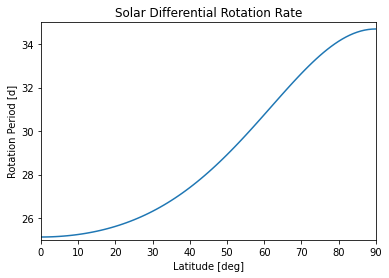

In [5]:
plt.figure()
plt.plot(latitudes, [this_period.value for this_period in rotation_period])
plt.ylim(25, 35)
plt.xlim(0, 90)
plt.ylabel('Rotation Period [{}]'.format(rotation_period[0].unit))
plt.xlabel('Latitude [deg]')
plt.title('Solar Differential Rotation Rate')

Nótese que solo generamos los valores de latitudes $\in [0,90]$ aunque las latitudes de un cuerpo esférico se definen en el rango $[-90, 90]$, esto lo hicimos porque la ecuación de rotación diferencial es simétrica.
También se puede notar que entre más alejado del ecuador, mayor es el periodo de rotación. Por ende, se puede concluir que cerca del ecuador la velocidad de rotación es mayor.

# Visualización sobre imagen del Sol

Para visualizar la rotación diferencial, se mostrará la distancia que se traslada un punto en cada latitud del Sol en un periodo de 4 días.

El primer paso es obtener el archivo fits del Sol proporcionado por SunPy que contiene la información emitida en la longitud de onda de $17.1$ nanómetros.

In [6]:
aia_map = sunpy.map.Map(sunpy.data.sample.AIA_171_IMAGE)

Luego generamos los arrays que contienen las coordenadas iniciales, el primero `hpc_y`contiene las coordenadas $[-700, -600, \ldots, 700]$ en arcosegundos y el segundo `hpc_x` contiene la misma cantidad de elementos que `hpc_y` pero todos son $0$ arcosegundos.

In [7]:
hpc_y = np.arange(-700, 800, 100) * u.arcsec
hpc_x = np.zeros_like(hpc_y)

A continuación definimos variables para que el periodo que vamos a graficar sea de 4 días terrestres.

In [8]:
dt = TimeDelta(4*u.day)
future_date = aia_map.date + dt

## Creación de figura
Mostraremos la imagen del Sol utilizando Pyplot y las funciones de graficación específicas de SunPy. Para esto creamos una figura `fig` donde vamos a generar una gráfica encima de una proyección de la imagen del Sol `aia_map`.

Nótese que es importante incluir la opción `clip_interval` cuando se va a graficar encima de la imagen del Sol porque esto nos permite remover los pixeles que son en extremo brillante o completamente oscuros, permitiendo una mejor apreciación del rango medio de la imagen.

## Generación de coordenadas futuras
Para cada par de coordenadas $(x,y)$ creamos un objeto de clase SkyCoord (astropy) que represente las coordenadas iniciales, además le proporcionamos el marco de coordenadas del objeto `aia_map` como referencia.

Luego obtenemos la coordenada donde se encontrará el punto inicial en la fecha `future_date`, que como establecimos anteriormente será el tiempo transcurrido dentro de 4 días terrestres.

Finalmente generamos el objeto `coord` que representa ambas coordenadas juntas, lo cual luego nos permitirá usar el método `plot_cord` de astropy para dibujar las líneas de progresión para cada punto.

## Mostrar figura
Para finalizar, ajustamos los límites de los ejes de la gráfica y la mostramos.

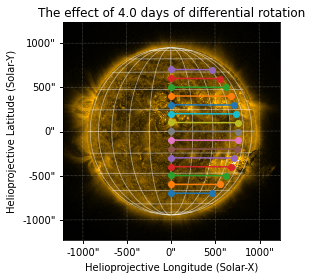

In [9]:
# Creación de figura
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax, clip_interval=(1, 99.99)*u.percent)
ax.set_title('The effect of {} days of differential rotation'.format(dt.to(u.day).value))
aia_map.draw_grid(axes=ax)

# Generación de coordenadas futuras
for this_hpc_x, this_hpc_y in zip(hpc_x, hpc_y):
    start_coord = SkyCoord(this_hpc_x, this_hpc_y, frame=aia_map.coordinate_frame)
    rotated_coord = solar_rotate_coordinate(start_coord, time=future_date)
    coord = SkyCoord([start_coord.Tx, rotated_coord.Tx],
                     [start_coord.Ty, rotated_coord.Ty],
                     frame=aia_map.coordinate_frame)
    ax.plot_coord(coord, 'o-')

# Mostrar figura
ax.set_ylim(0, aia_map.data.shape[1])
ax.set_xlim(0, aia_map.data.shape[0])

plt.show()